# Cohort Analysis - Worker

# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh
import warnings
warnings.filterwarnings('ignore')
from operator import attrgetter
from matplotlib import colors as mcolors
import matplotlib.ticker as mtick
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10,
                    'font.sans-serif':'arial'})

In [ ]:
worker = pd.read_csv('diligence_initech.fake_initech_worker_data.csv', parse_dates=[0])

# EDA

## Distribution of worker activities

Text(0, 0.5, '# workers')

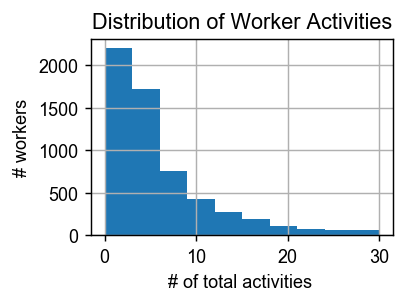

In [3]:
plt.figure(figsize=(3,2), dpi=130)
worker.groupby('worker_id').size().hist(range = (0,30))
plt.title('Distribution of Worker Activities')
plt.xlabel('# of total activities ')
plt.ylabel('# workers')

In [4]:
n_work = worker.groupby('worker_id').size()
mult_order_perc = np.sum(n_work > 1)/worker['worker_id'].nunique()
print(f'{100 * mult_order_perc:.2f}% of workers work more than once.')


78.15% of workers work more than once.


In [5]:
worker.sort_values('month', inplace=True)

# by month segmentation
worker_by_month = worker.groupby('month').agg({'worker_id': 'size', 
                             'revenue' : 'sum',
                             'revenue_minus_direct_costs' : 'sum'})

worker_by_month_by_market = worker.groupby(['month', 'market']).agg({'worker_id': 'size', 
                             'revenue' : 'sum',
                             'revenue_minus_direct_costs' : 'sum'})

worker['market'].unique()

map_func = {'sf-bay-area':'big','los-angeles':'big',
            'washington-dc':'big','new-york-city':'big',
            'other':'small', 'kansas-city':'small',
            'chicago':'small','austin':'small', 'minneapolis':'small'}
worker['city'] = worker['market'].map(map_func)


small_worker = worker[worker['city']=='small'].groupby('worker_id').size()
big_worker = worker[worker['city']=='big'].groupby('worker_id').size()

small_city_retention_rate = (worker[worker['city']=='small'].groupby('worker_id').size() > 1 ).sum() / worker[worker['city']=='small']['worker_id'].nunique()
print(f'{100 * small_city_retention_rate:.2f}% of workers work more than once in small cities.')


large_city_retention_rate=(worker[worker['city']=='big'].groupby('worker_id').size() > 1 ).sum() / worker[worker['city']=='big']['worker_id'].nunique()
print(f'{100 * large_city_retention_rate:.2f}% of workers work more than once in big cities.')


## Difference between markets

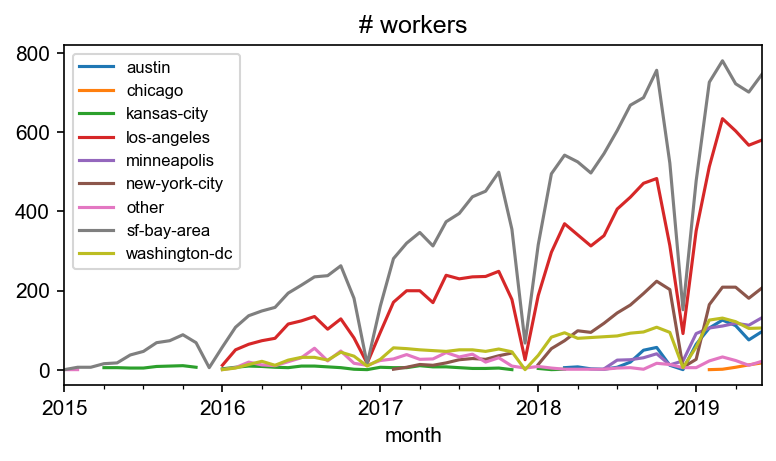

In [11]:
plt.figure(figsize = (6,3), dpi=150)
worker_by_month_by_market['worker_id'].unstack(1).plot(ax=plt.gca(), title = '# workers')
plt.legend(loc='upper left', fontsize=8)

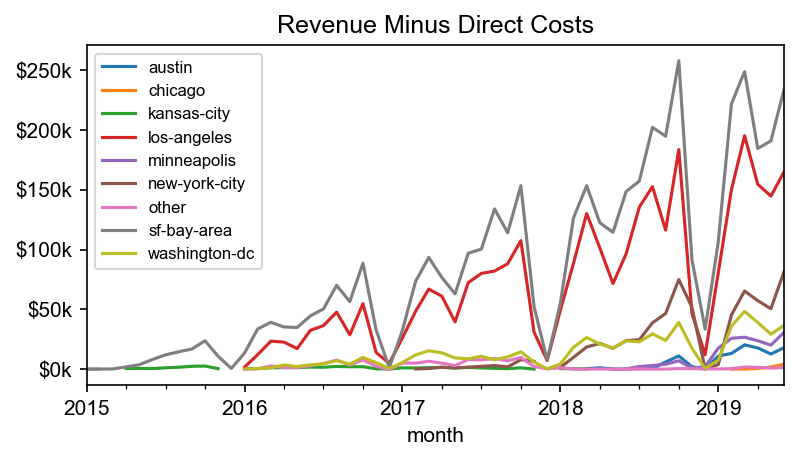

In [12]:
def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fk' % (x*1e-3)
plt.figure(figsize = (6,3), dpi=150)
worker_by_month_by_market['revenue_minus_direct_costs'].unstack(1).plot(ax=plt.gca(), title = 'Revenue Minus Direct Costs')
#plt.ylim([0,100000])
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
plt.legend(loc='upper left', fontsize=8)


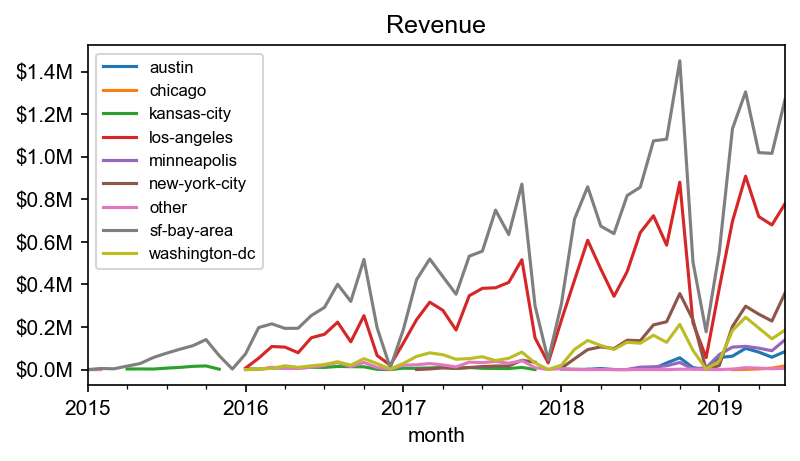

In [13]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)
plt.figure(figsize = (6,3), dpi=150)
worker_by_month_by_market['revenue'].unstack(1).plot(ax=plt.gca(), title = 'Revenue')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(millions))
plt.legend(loc='upper left', fontsize=8)


In [18]:
test = worker_by_month_by_market['revenue_minus_direct_costs']/worker_by_month_by_market['worker_id']

In [25]:
worker.isnull().sum()

month                         0
worker_id                     0
market                        0
revenue                       0
revenue_minus_direct_costs    0
city                          0
dtype: int64

# Worker Retention

In [26]:
worker = pd.read_csv('diligence_initech.fake_initech_worker_data.csv', parse_dates=[0])
worker = worker.groupby(['month', 'worker_id']).agg({'revenue':'sum',
                                                     'revenue_minus_direct_costs': 'sum'}).reset_index()
worker['month_ts'] = pd.to_datetime(worker['month'])
worker['month'] = worker['month_ts'].dt.to_period('M')

worker['cohort'] = worker.groupby(['worker_id'])['month'].transform('min')

In [27]:
worker_num_cohort = worker.groupby(['cohort', 'month'])\
                    .agg(n_workerloyers = ('worker_id','nunique'))\
                    .reset_index(drop=False)

worker_num_cohort['period'] = (worker_num_cohort['month'] - worker_num_cohort['cohort']).apply(attrgetter('n'))


worker_num_cohort_pivot = worker_num_cohort.pivot(index = 'cohort',
                                            columns = 'period',
                                            values='n_workerloyers')
worker_cohort_size = worker_num_cohort_pivot[0]
retention_matrix = worker_num_cohort_pivot.divide(worker_cohort_size, axis=0)
sub_retention_matrix = retention_matrix.iloc[11:,:42]
sub_cohort_size = worker_cohort_size[11:]

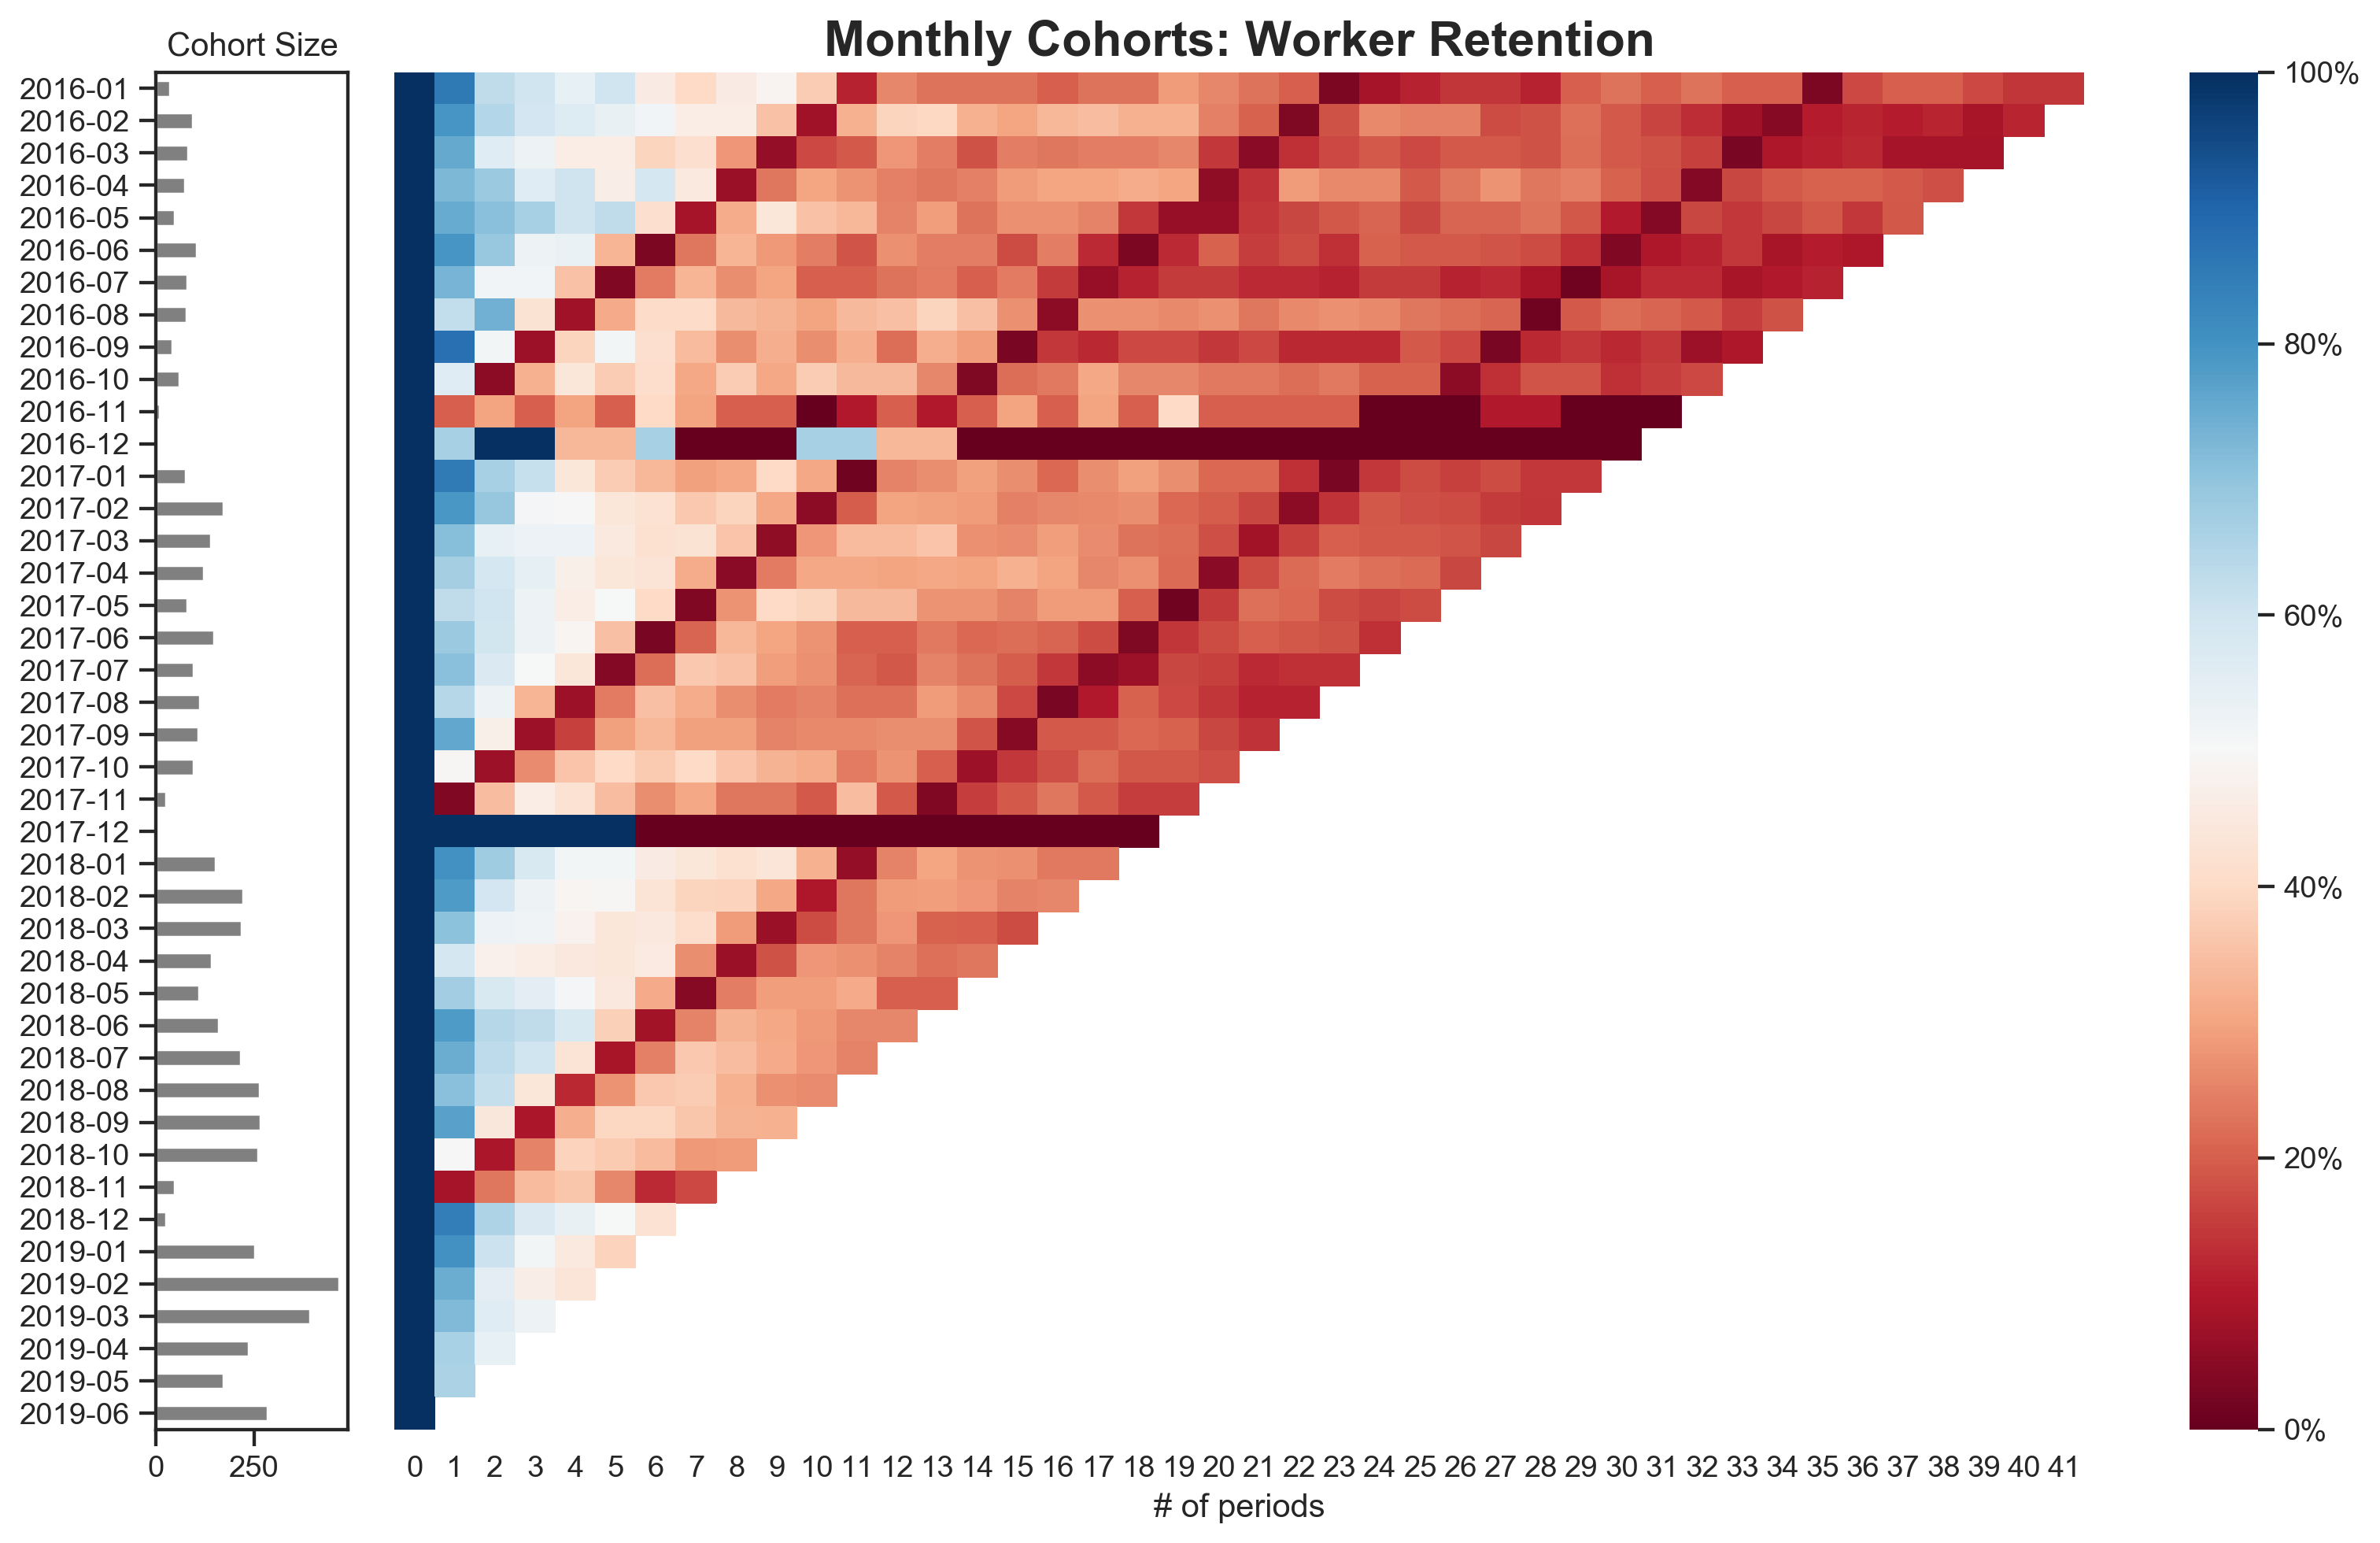

In [28]:
mask = np.zeros(sub_retention_matrix.shape)
for r in range(mask.shape[0]):
    for c in range(mask.shape[1]):
        if r+c > 41:
            mask[r,c] = 1
sns.set(style='white')
fig, ax = plt.subplots(1, 2, figsize=(13, 8), 
                       sharey=False, dpi=250, gridspec_kw={'width_ratios': [1, 11]})

# cohort size
cohort_size_df = pd.DataFrame(sub_cohort_size).rename(columns={0: 'cohort_size'})
white_cmap = mcolors.ListedColormap(['white'])
cohort_size_df.sort_index(ascending=False).plot(kind='barh', ax=ax[0],legend=False, title='Cohort Size', color='grey')
ax[0].tick_params(axis="both", which="both", bottom="on", left="on", labelbottom="on",labelleft="on")
ax[0].set_xlabel('')
ax[0].set_ylabel('')


# retention matrix
sns.heatmap(sub_retention_matrix.fillna(0)*100, 
            mask=mask, 
            annot=False, 
            fmt='.0%', 
            cmap='RdBu',#'RdYlGn', 
            ax=ax[1],
            cbar_kws={'format': '%.0f%%', 'ticks': [0,20,40,60,80, 100]},
            vmax=100,
            vmin=0)
ax[1].set_ylim(42, 0)
ax[1].set_title('Monthly Cohorts: Worker Retention',fontsize=18, fontweight='bold')
ax[1].set(xlabel='# of periods',
          ylabel='', yticks=[])
#ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xticks(rotation=0) 


fig.tight_layout()

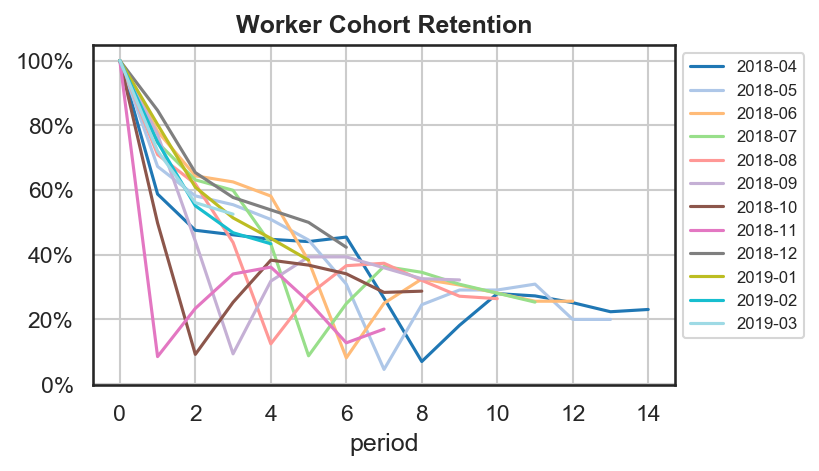

In [29]:
from matplotlib import cm

cmap = cm.get_cmap('tab20')

plt.figure(figsize=(5,3), dpi=150)
sub_retention_matrix.T.iloc[:,27:-3].plot(kind='line', ax=plt.gca(), cmap = cmap)
plt.legend(bbox_to_anchor=(1, 1), fontsize=8)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.grid()
plt.title('Worker Cohort Retention', fontweight = 'bold' )
plt.show()

# Revenue Cohort Analysis

In [30]:
worker_rev_cohort = worker.groupby(['cohort', 'month'])\
                    .agg(rev = ('revenue','sum'))\
                    .reset_index(drop=False)

worker_rev_cohort['period'] = (worker_rev_cohort['month'] - worker_rev_cohort['cohort']).apply(attrgetter('n'))


worker_rev_cohort_pivot = worker_rev_cohort.pivot(index = 'cohort',
                                            columns = 'period',
                                            values='rev')
worker_cohort_initial_rev = worker_rev_cohort_pivot[0]
retention_rev_matrix = worker_rev_cohort_pivot.divide(worker_cohort_initial_rev, axis=0)
sub_retention_rev_matrix = retention_rev_matrix.iloc[11:,:42]
sub_inital_rev = worker_cohort_initial_rev[11:]

(array([665., 402., 108.,  25.,   8.,   2.,   6.,   1.,   6.,   2.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

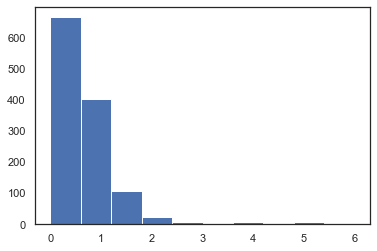

In [31]:
plt.hist(retention_rev_matrix.values.ravel(), range = (0,6))

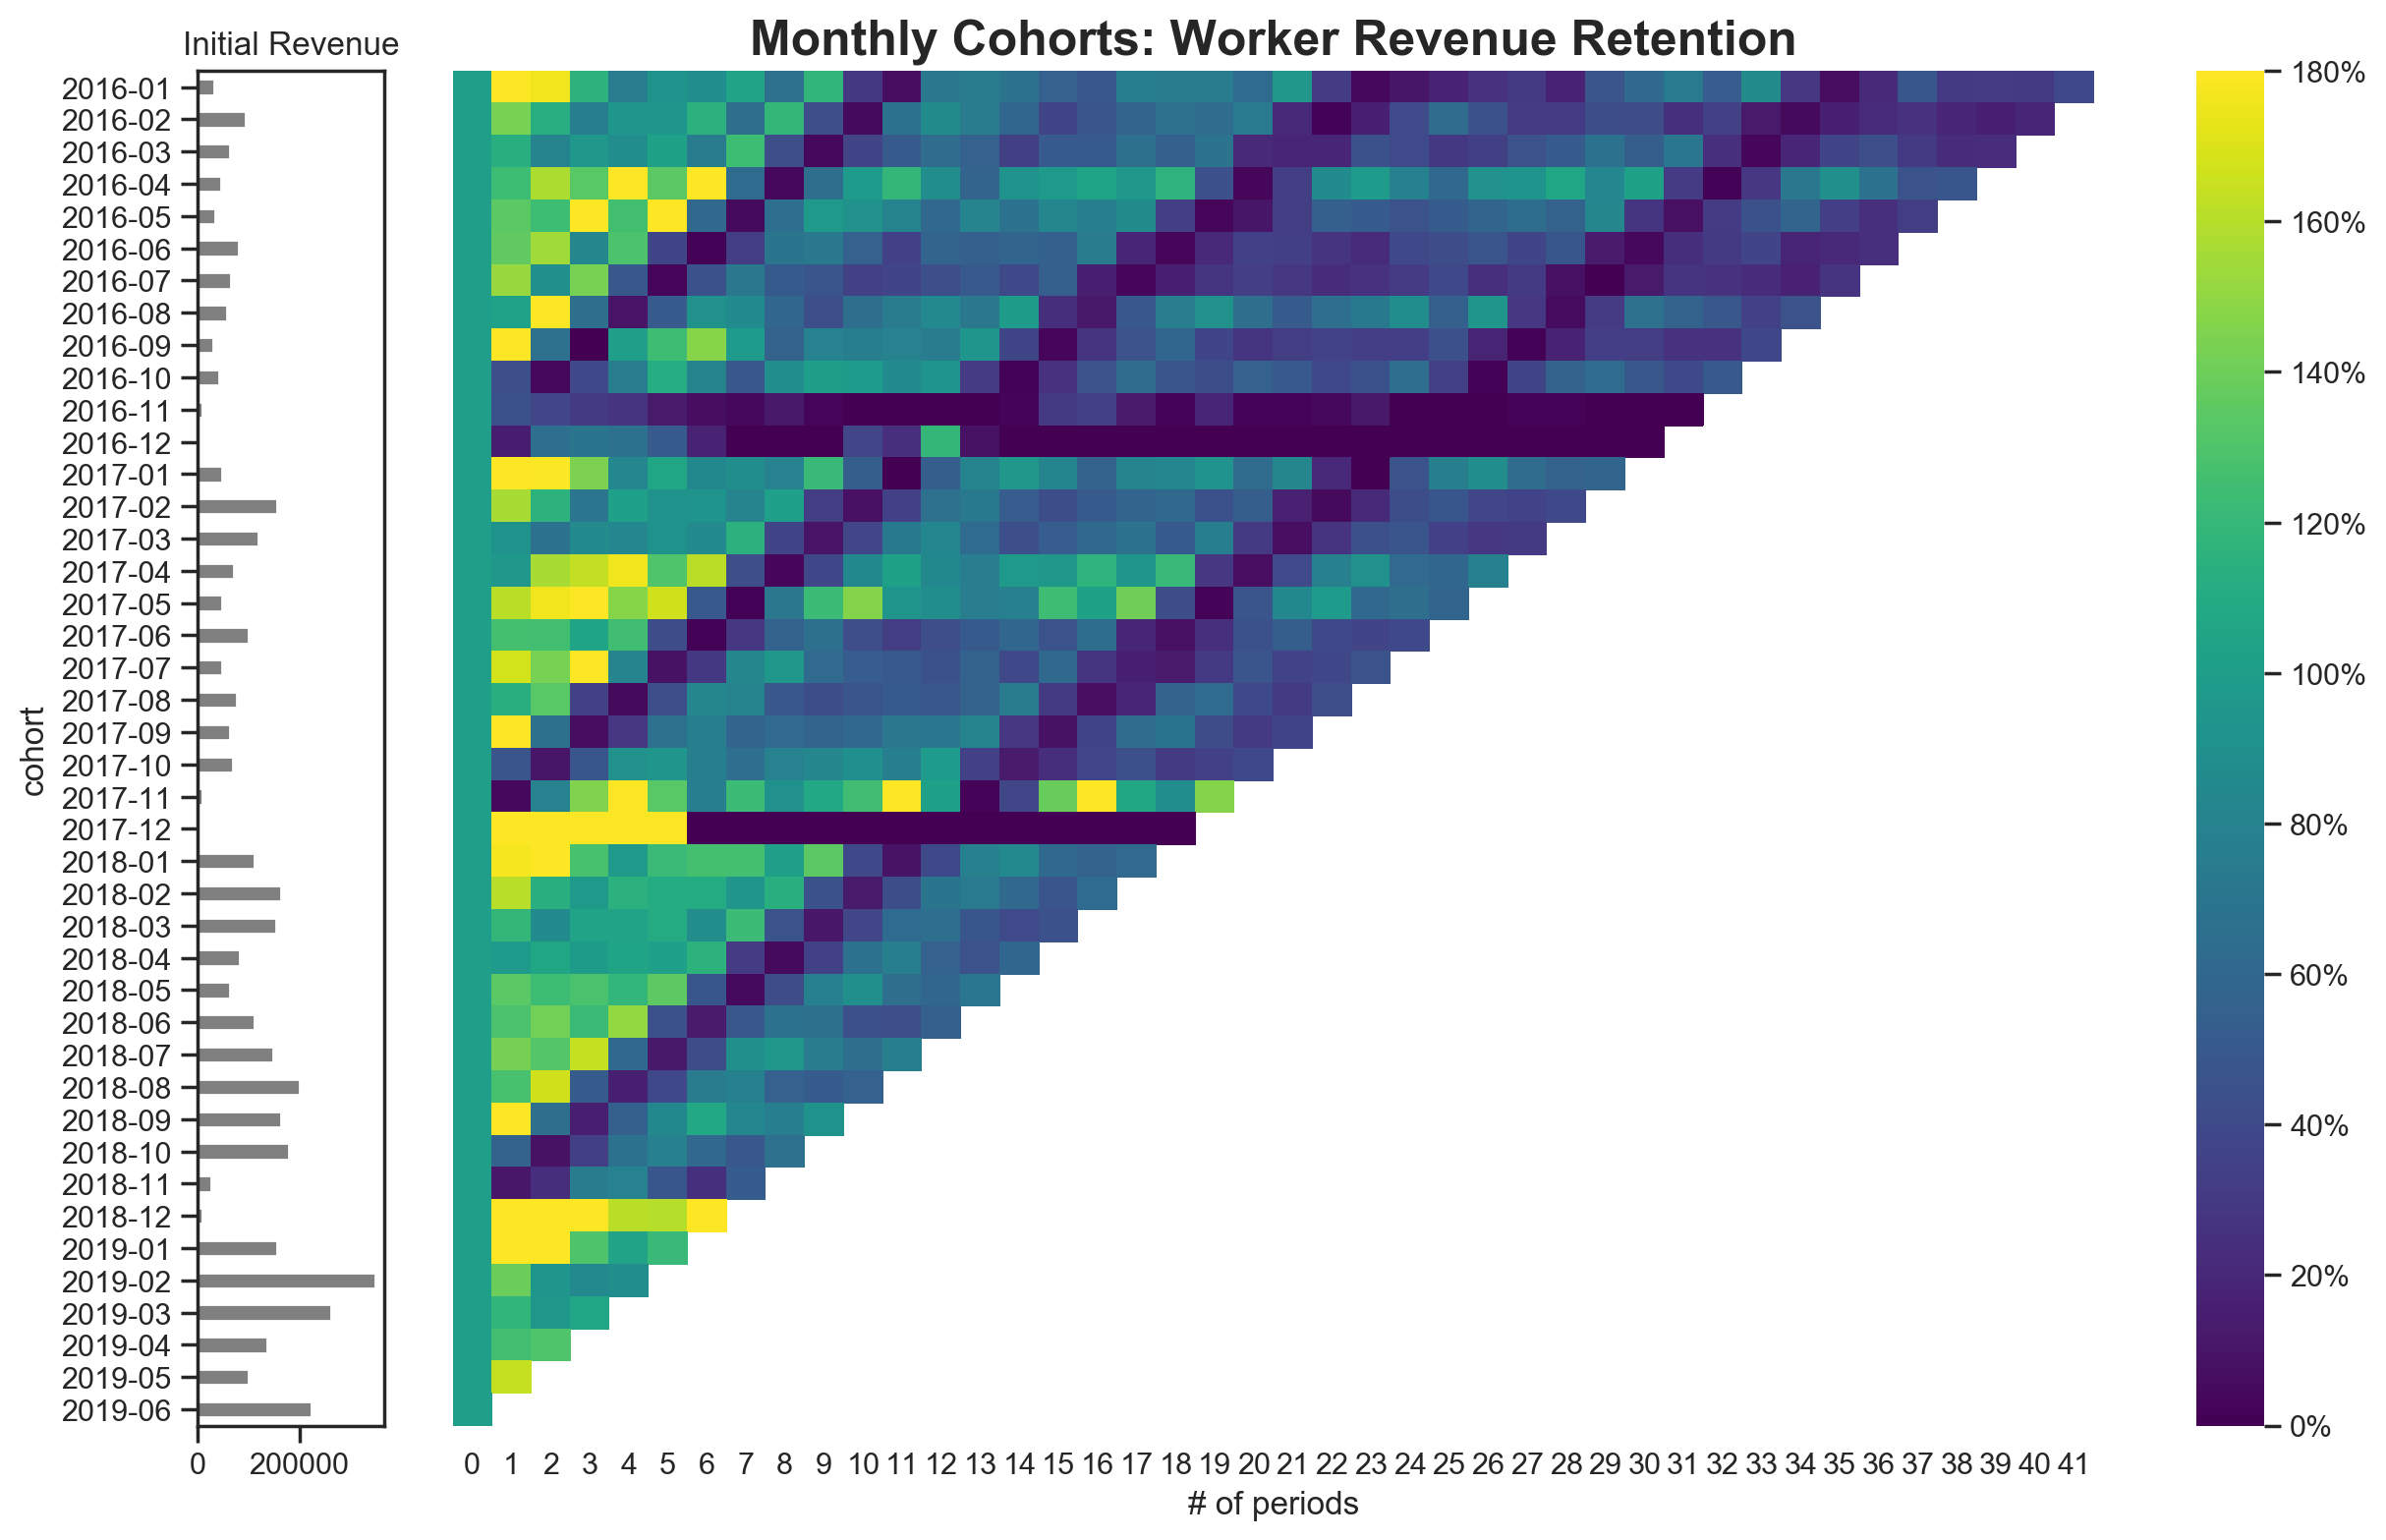

In [32]:
mask = np.zeros(sub_retention_matrix.shape)
for r in range(mask.shape[0]):
    for c in range(mask.shape[1]):
        if r+c > 41:
            mask[r,c] = 1
sns.set(style='white')
fig, ax = plt.subplots(1, 2, figsize=(13, 8), sharey=False, dpi=200, gridspec_kw={'width_ratios': [1, 11]})

# cohort size
initial_rev_df = pd.DataFrame(sub_inital_rev).rename(columns={0: 'initial_revenue'})
white_cmap = mcolors.ListedColormap(['white'])
initial_rev_df.sort_index(ascending=False).plot(kind='barh', ax=ax[0],legend=False, title='Initial Revenue', color='grey')
ax[0].tick_params(axis="both", which="both", bottom="on", left="on", labelbottom="on",labelleft="on")
#ax[0].set_ylim(42, 0)

# retention matrix
sns.heatmap(sub_retention_rev_matrix.fillna(0)*100, 
            mask=mask, 
            annot=False, 
            fmt='.0%', 
            cmap='viridis',#'RdYlGn', 
            ax=ax[1],
            cbar_kws={'format': '%.0f%%', 'ticks': list(range(0,200,20))},
            vmax=180,
            vmin=0)
ax[1].set_ylim(42, 0)
ax[1].set_title('Monthly Cohorts: Worker Revenue Retention',fontsize=18, fontweight='bold')
ax[1].set(xlabel='# of periods',
          ylabel='', yticks=[])
#ax[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xticks(rotation=0) 


fig.tight_layout()

# Cohort LTV

In [33]:
from matplotlib import cm

cmap = cm.get_cmap('tab20')

In [34]:
worker['period'] = (worker['month']-worker['cohort']).apply(attrgetter('n'))


In [35]:


# calculate cohort LTV & cumulative cohort LTV
cohort_LTV = (worker.groupby(['cohort', 'period'])['revenue'].sum()/\
            worker.groupby(['cohort', 'period'])['worker_id'].nunique()).to_frame().unstack(level=0)[0]

# fill in the missing month
missing_month = cohort_LTV.columns[10]+1
cohort_LTV[missing_month] = np.nan
cohort_LTV = cohort_LTV.T.sort_index().T
shape = cohort_LTV.shape[0]
for r in range(shape):
    for c in range(shape):
        if r + c < shape:
            if np.isnan(cohort_LTV.iloc[r,c]):
                cohort_LTV.iloc[r,c] = 0

cohort_LTV_cumsum = cohort_LTV.cumsum()

# calculate weighted average
avg_df = pd.merge(cohort_LTV_cumsum.T, cohort_size_df,  left_index=True, right_index=True, how='left')

avg_df = avg_df.iloc[38:,:]

period_dat = avg_df[0].iloc[:(16)].values
cohort_sizes = avg_df['cohort_size'].iloc[:16].values

avg = []
for i in range(0,16):
    period_dat = avg_df[i].iloc[:(16-i)].values
    cohort_sizes = avg_df['cohort_size'].iloc[:(16-i)].values
    wt_avg = sum((period_dat * cohort_sizes))/sum(cohort_sizes)
    avg.append(wt_avg)
    


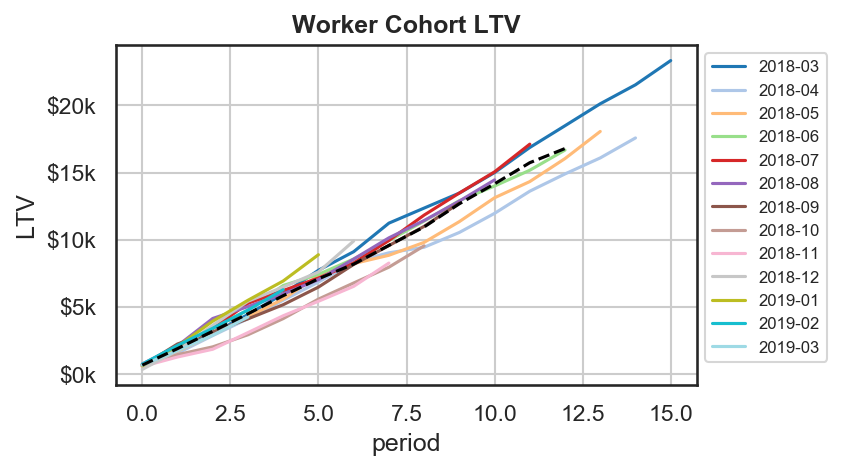

In [36]:

plt.figure(figsize=(5,3), dpi=150)
cohort_LTV_cumsum.iloc[:,38:-3].plot(kind='line', ax=plt.gca(),cmap=cmap)
plt.plot(cohort_LTV_cumsum.index[:13], avg[:-3], color='black', linestyle='--')
plt.title('Worker Cohort LTV',  fontweight='bold')
plt.ylabel('LTV')
plt.grid()
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
plt.legend(bbox_to_anchor=(1, 1), fontsize=8 )

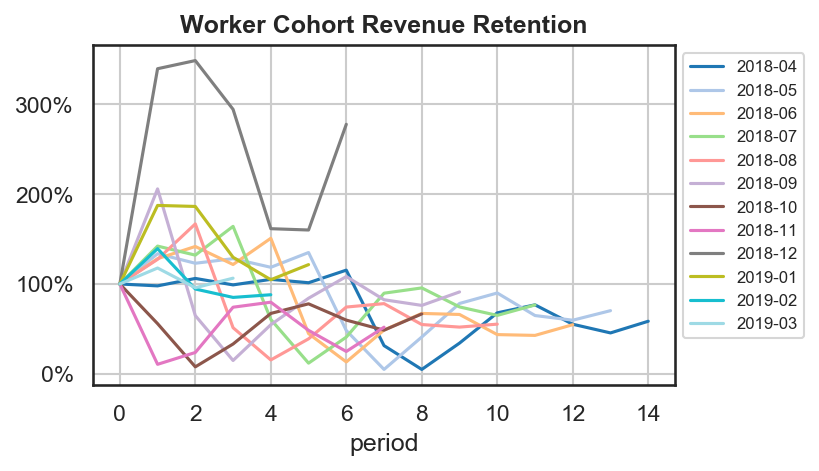

In [37]:
from matplotlib import cm

cmap = cm.get_cmap('tab20')
plt.figure(figsize=(5,3), dpi=150)
sub_retention_rev_matrix.T.iloc[:,27:-3].plot(kind='line', ax=plt.gca(), cmap = cmap)
plt.legend(bbox_to_anchor=(1, 1), fontsize=8)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.grid()
plt.title('Worker Cohort Revenue Retention', fontweight = 'bold' )
plt.show()

In [38]:
cohort_size_df = pd.DataFrame(sub_cohort_size).rename(columns={0: 'cohort_size'})


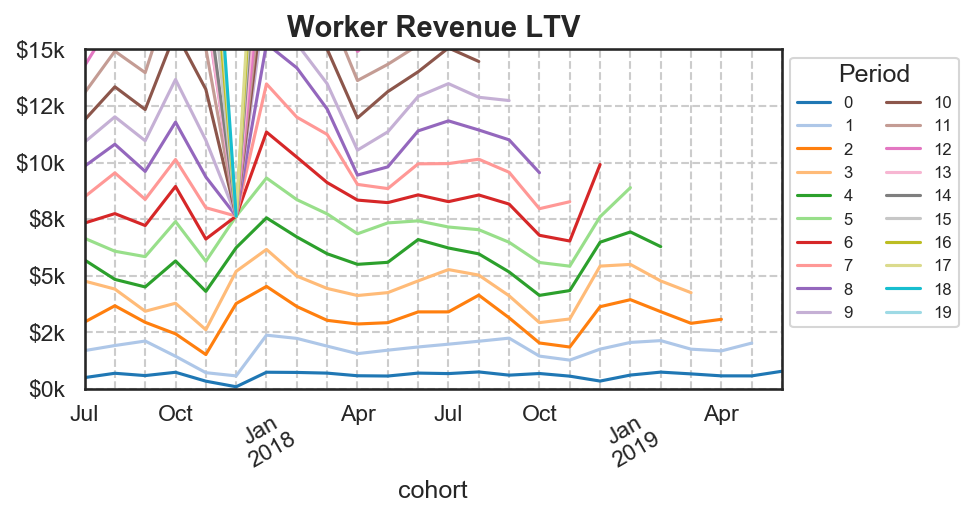

In [39]:
plt.figure(figsize=(6,3), dpi=150)
dat = cohort_LTV_cumsum.T.iloc[30:,:20].reset_index().set_index('cohort')
dat.plot(kind='line',  ax=plt.gca(), cmap=cmap)
plt.title('Worker Revenue LTV', fontsize=14, fontweight='bold')
plt.xticks(rotation=30) 
plt.legend( bbox_to_anchor = [1,1], ncol=2 , title='Period', fontsize=8)
plt.grid(True,'both', zorder=0,linestyle='dashed')
plt.ylim([0, 15000])
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(thousands))

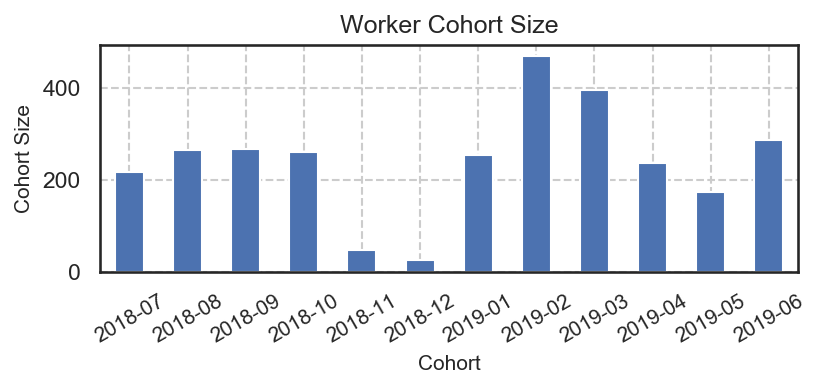

In [256]:
plt.figure(figsize=(6,2), dpi=150)
cohort_size_df.iloc[30:].plot(kind='bar', ax=plt.gca(),legend=None)
plt.title('Worker Cohort Size')
plt.ylabel('Cohort Size', fontsize=10)
plt.xlabel('Cohort', fontsize=10)
plt.grid(True,'both', zorder=0,linestyle='dashed')
#plt.xlim(cohort_size_df.index[20],cohort_size_df.index[-1])
plt.xticks(rotation=30, fontsize=10)
plt.show()

In [257]:
emp_cohort_size = pd.read_csv('employer_cohort_size.csv')

emp_cohort_size.columns = ['cohort', 'employer_size']

emp_cohort_size['cohort'] = pd.to_datetime(emp_cohort_size['cohort']).dt.to_period('M')

size_compare_df = pd.merge(cohort_size_df, emp_cohort_size, 
                           left_index=True, right_on = 'cohort')

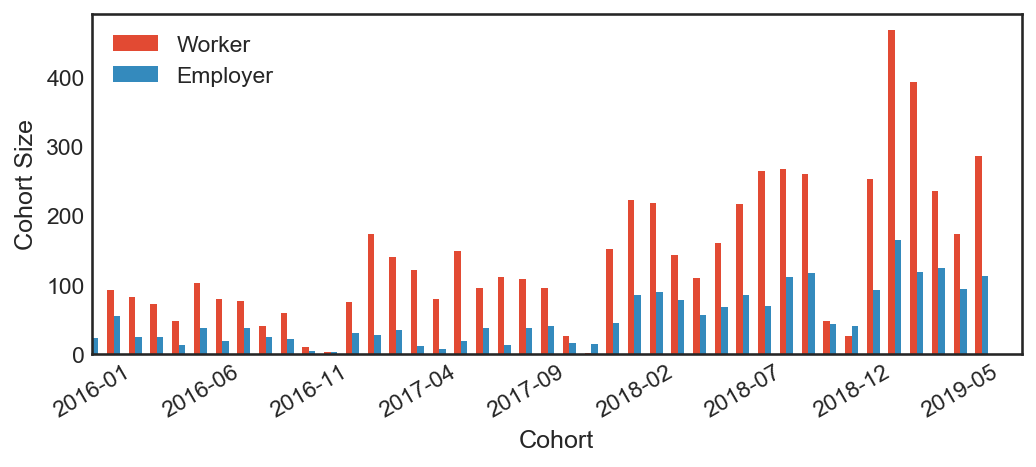

In [312]:
plt.style.use('seaborn-white')
plt.figure(figsize=(8,3),dpi=150)
ind = np.arange(size_compare_df.shape[0])
bar_width = 0.3
plt.bar(x=ind, width = bar_width, edgecolor = "none",height=size_compare_df['cohort_size'], label = 'Worker')
plt.bar(x=ind+bar_width, width=bar_width, edgecolor = "none", height=size_compare_df['employer_size'], label= 'Employer')
plt.xlim([10,size_compare_df.shape[0]+1])
plt.xticks(ind[::5] + bar_width/ 2, size_compare_df['cohort'][::5],rotation=30)#size_compare_df.index)
plt.xlabel('Cohort')
plt.ylabel('Cohort Size')
plt.legend()
plt.show()